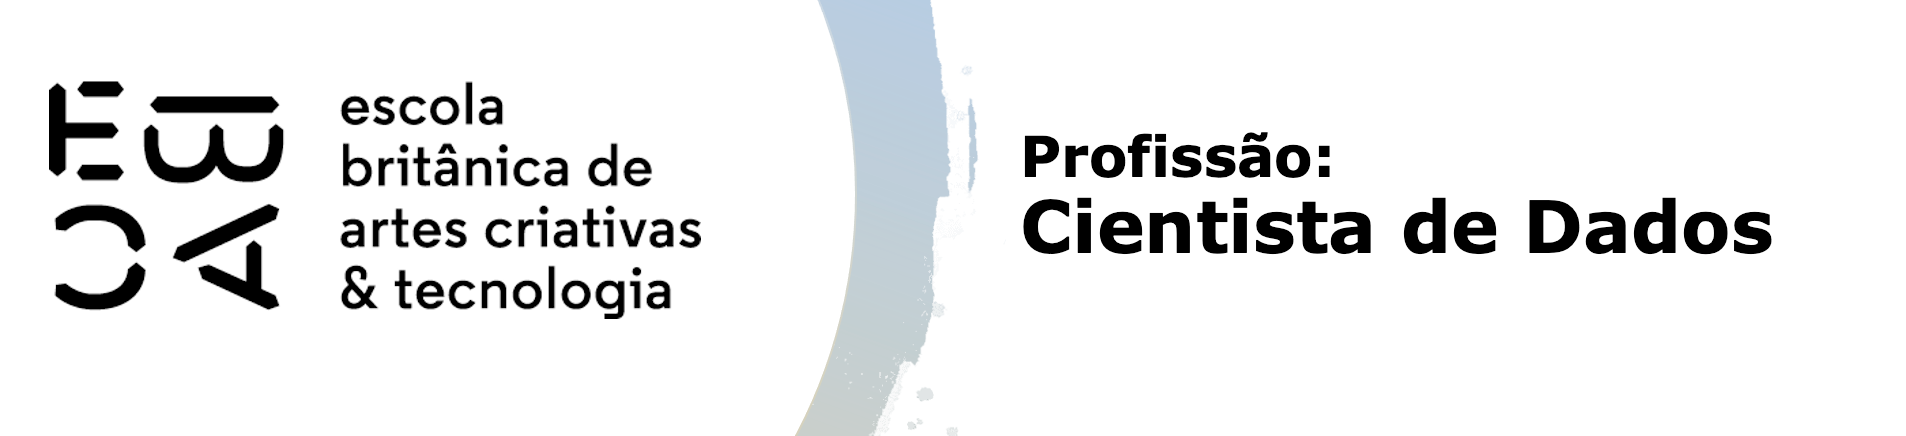

# Módulo 38: Tarefa I

Neste projeto, estamos construindo um credit scoring para cartão de crédito, em um desenho amostral com 15 safras, e utilizando 12 meses de performance.

Carregue a base de dados ```credit_scoring.ftr```.

In [ ]:
!pip install pycaret

In [1]:
# Importando as bibliotecas necessárias:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from scipy.stats import ks_2samp
from scipy.stats import t
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from pycaret.regression import create_model
from pycaret.classification import *
import plotly.express as px
from scipy.stats import ks_2samp
from scipy.stats import ttest_ind
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier


import warnings
warnings.filterwarnings("ignore")
%matplotlib inline


In [3]:
# Importando a base de dados

df = pd.read_feather('credit_scoring.ftr')
df.head()

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
0,2015-01-01,5733,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,False
1,2015-01-01,727,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,False
2,2015-01-01,6374,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.29,False
3,2015-01-01,9566,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.772603,2.0,13721.17,False
4,2015-01-01,9502,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.432877,1.0,2891.08,False


## Amostragem

Separe os três últimos meses como safras de validação *out of time* (oot).

Variáveis:<br>
Considere que a variável ```data_ref``` não é uma variável explicativa, é somente uma variável indicadora da safra, e não deve ser utilizada na modelagem. A variávei ```index``` é um identificador do cliente, e também não deve ser utilizada como covariável (variável explicativa). As restantes podem ser utilizadas para prever a inadimplência, incluindo a renda.


In [4]:
# Certificando-se de que 'data_ref' é do tipo datetime
df['data_ref'] = pd.to_datetime(df['data_ref'])

# Ordenando o dataframe por 'data_ref'
df.sort_values('data_ref', inplace=True)

# Encontrando a data de corte para os últimos três meses
cutoff_date = df['data_ref'].max() - pd.DateOffset(months=3)

# Separando o dataframe em treino e validação (oot)
train_df = df[df['data_ref'] < cutoff_date]
oot_df = df[df['data_ref'] >= cutoff_date]

# Removendo as colunas 'data_ref' e 'index' que não serão usadas na modelagem
train_df = train_df.drop(columns=['data_ref', 'index'])
oot_df = oot_df.drop(columns=['data_ref', 'index'])


## Descritiva básica univariada

- Descreva a base quanto ao número de linhas, número de linhas para cada mês em ```data_ref```.
- Faça uma descritiva básica univariada de cada variável. Considere as naturezas diferentes: qualitativas e quantitativas.

In [5]:
# Número de linhas
num_rows = len(df)
print(f"Número de linhas: {num_rows}")

# Número de linhas para cada mês em 'data_ref'
num_rows_per_month = df['data_ref'].value_counts()
print("\nNúmero de linhas para cada mês em 'data_ref':")
print(num_rows_per_month)

Número de linhas: 750000

Número de linhas para cada mês em 'data_ref':
2015-01-01    50000
2015-02-01    50000
2015-03-01    50000
2015-04-01    50000
2015-05-01    50000
2015-06-01    50000
2015-07-01    50000
2015-08-01    50000
2015-09-01    50000
2015-10-01    50000
2015-11-01    50000
2015-12-01    50000
2016-01-01    50000
2016-02-01    50000
2016-03-01    50000
Name: data_ref, dtype: int64


In [6]:
# Descritiva básica univariada de cada variável
for col in df.columns:
    print(f"\nDescritiva básica univariada para '{col}':")
    if df[col].dtype == 'object':  # Variáveis qualitativas
        print(df[col].value_counts())
    else:  # Variáveis quantitativas
        print(df[col].describe())


Descritiva básica univariada para 'data_ref':
count                  750000
unique                     15
top       2015-01-01 00:00:00
freq                    50000
first     2015-01-01 00:00:00
last      2016-03-01 00:00:00
Name: data_ref, dtype: object

Descritiva básica univariada para 'index':
count    750000.000000
mean       8319.272793
std        4809.281774
min           0.000000
25%        4147.000000
50%        8324.000000
75%       12487.000000
max       16649.000000
Name: index, dtype: float64

Descritiva básica univariada para 'sexo':
F    504580
M    245420
Name: sexo, dtype: int64

Descritiva básica univariada para 'posse_de_veiculo':
N    457954
S    292046
Name: posse_de_veiculo, dtype: int64

Descritiva básica univariada para 'posse_de_imovel':
S    503692
N    246308
Name: posse_de_imovel, dtype: int64

Descritiva básica univariada para 'qtd_filhos':
count    750000.000000
mean          0.433251
std           0.739379
min           0.000000
25%           0.000000
5

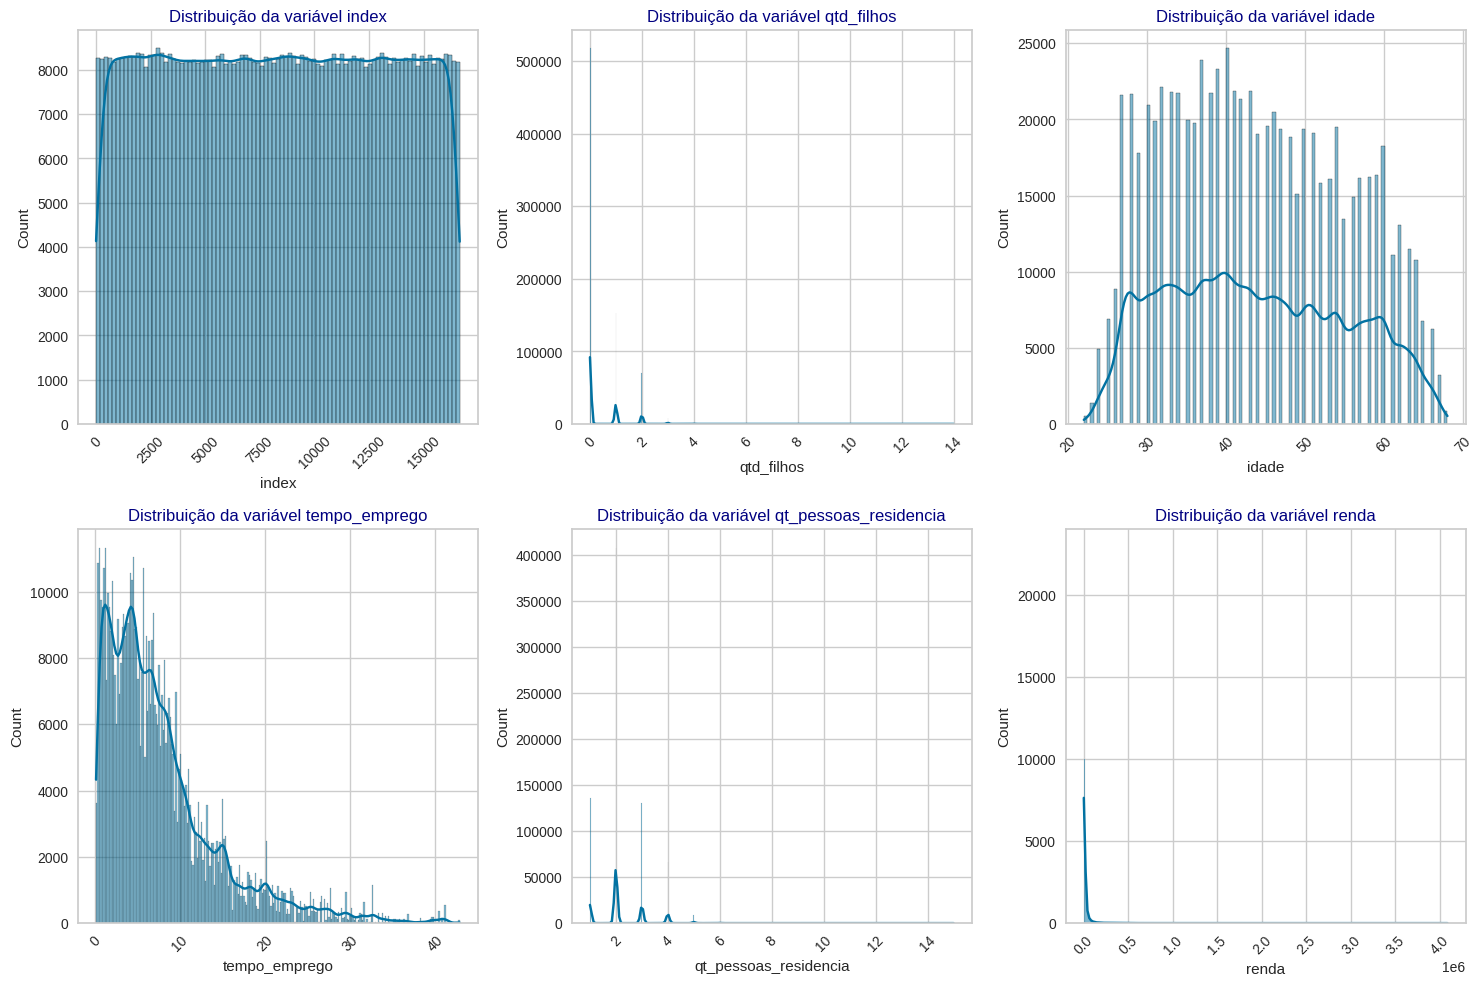

In [7]:
# Gráficos para variáveis quantitativas
quant_vars = df.select_dtypes(include=[np.number]).columns
n_rows = int(np.ceil(len(quant_vars)/3))
fig, axs = plt.subplots(n_rows, 3, figsize=(15, 5*n_rows))
axs = axs.flatten()  # para facilitar a iteração
for i, col in enumerate(quant_vars):
    sns.histplot(data=df, x=col, kde=True, ax=axs[i])
    axs[i].set_title(f'Distribuição da variável {col}', color='navy')
    plt.setp(axs[i].xaxis.get_majorticklabels(), rotation=45)
plt.tight_layout()
plt.show()

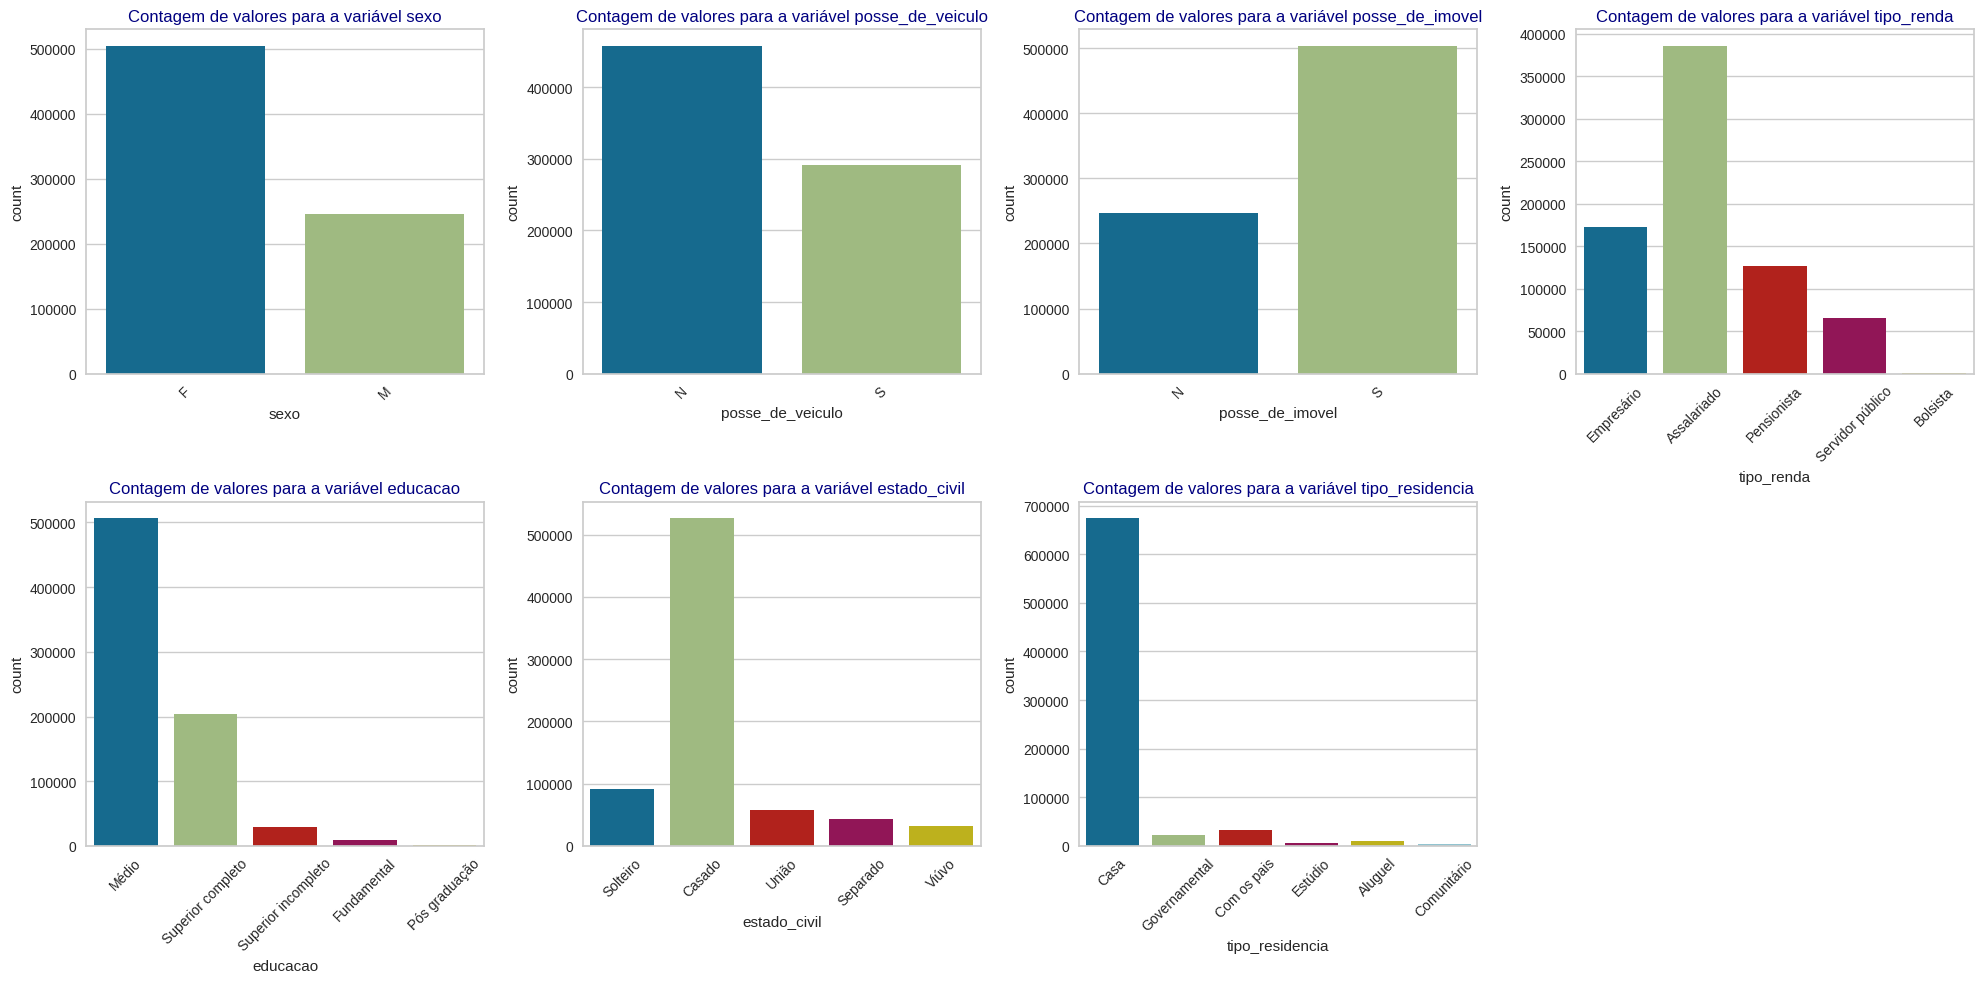

In [8]:
# Gráficos para variáveis qualitativas
qual_vars = df.select_dtypes(include=['object']).columns
n_rows = int(np.ceil(len(qual_vars)/4))  # Alterado para 4 gráficos por linha
fig, axs = plt.subplots(n_rows, 4, figsize=(20, 5*n_rows))  # Alterado para 4 gráficos por linha
axs = axs.flatten()  # para facilitar a iteração
for i, col in enumerate(qual_vars):
    sns.countplot(data=df, x=col, ax=axs[i])
    axs[i].set_title(f'Contagem de valores para a variável {col}', color='navy')
    plt.setp(axs[i].xaxis.get_majorticklabels(), rotation=45)
if len(qual_vars) < len(axs):  # Se houver mais subplots do que gráficos
    fig.delaxes(axs[-1])  # Remove o último gráfico
plt.tight_layout()
plt.show()


## Descritiva bivariada

Faça uma análise descritiva bivariada de cada variável

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 750000 entries, 0 to 749999
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   data_ref               750000 non-null  datetime64[ns]
 1   index                  750000 non-null  int64         
 2   sexo                   750000 non-null  object        
 3   posse_de_veiculo       750000 non-null  object        
 4   posse_de_imovel        750000 non-null  object        
 5   qtd_filhos             750000 non-null  int64         
 6   tipo_renda             750000 non-null  object        
 7   educacao               750000 non-null  object        
 8   estado_civil           750000 non-null  object        
 9   tipo_residencia        750000 non-null  object        
 10  idade                  750000 non-null  int64         
 11  tempo_emprego          624043 non-null  float64       
 12  qt_pessoas_residencia  750000 non-null  floa

In [10]:
# Para variáveis qualitativas, podemos usar uma tabela de contingência
qual_vars = df.select_dtypes(include=['object']).columns
for i in range(len(qual_vars)):
    for j in range(i+1, len(qual_vars)):
        contingency_table = pd.crosstab(df[qual_vars[i]], df[qual_vars[j]])
        print(f'Tabela de contingência entre {qual_vars[i]} e {qual_vars[j]}:')
        print(contingency_table)

Tabela de contingência entre sexo e posse_de_veiculo:
posse_de_veiculo       N       S
sexo                            
F                 371028  133552
M                  86926  158494
Tabela de contingência entre sexo e posse_de_imovel:
posse_de_imovel       N       S
sexo                           
F                156662  347918
M                 89646  155774
Tabela de contingência entre sexo e tipo_renda:
tipo_renda  Assalariado  Bolsista  Empresário  Pensionista  Servidor público
sexo                                                                        
F                235395       361      113774       108016             47034
M                150345         0       58938        18249             17888
Tabela de contingência entre sexo e educacao:
educacao  Fundamental   Médio  Pós graduação  Superior completo  \
sexo                                                              
F                5403  342166            591             137952   
M                3172  164670 

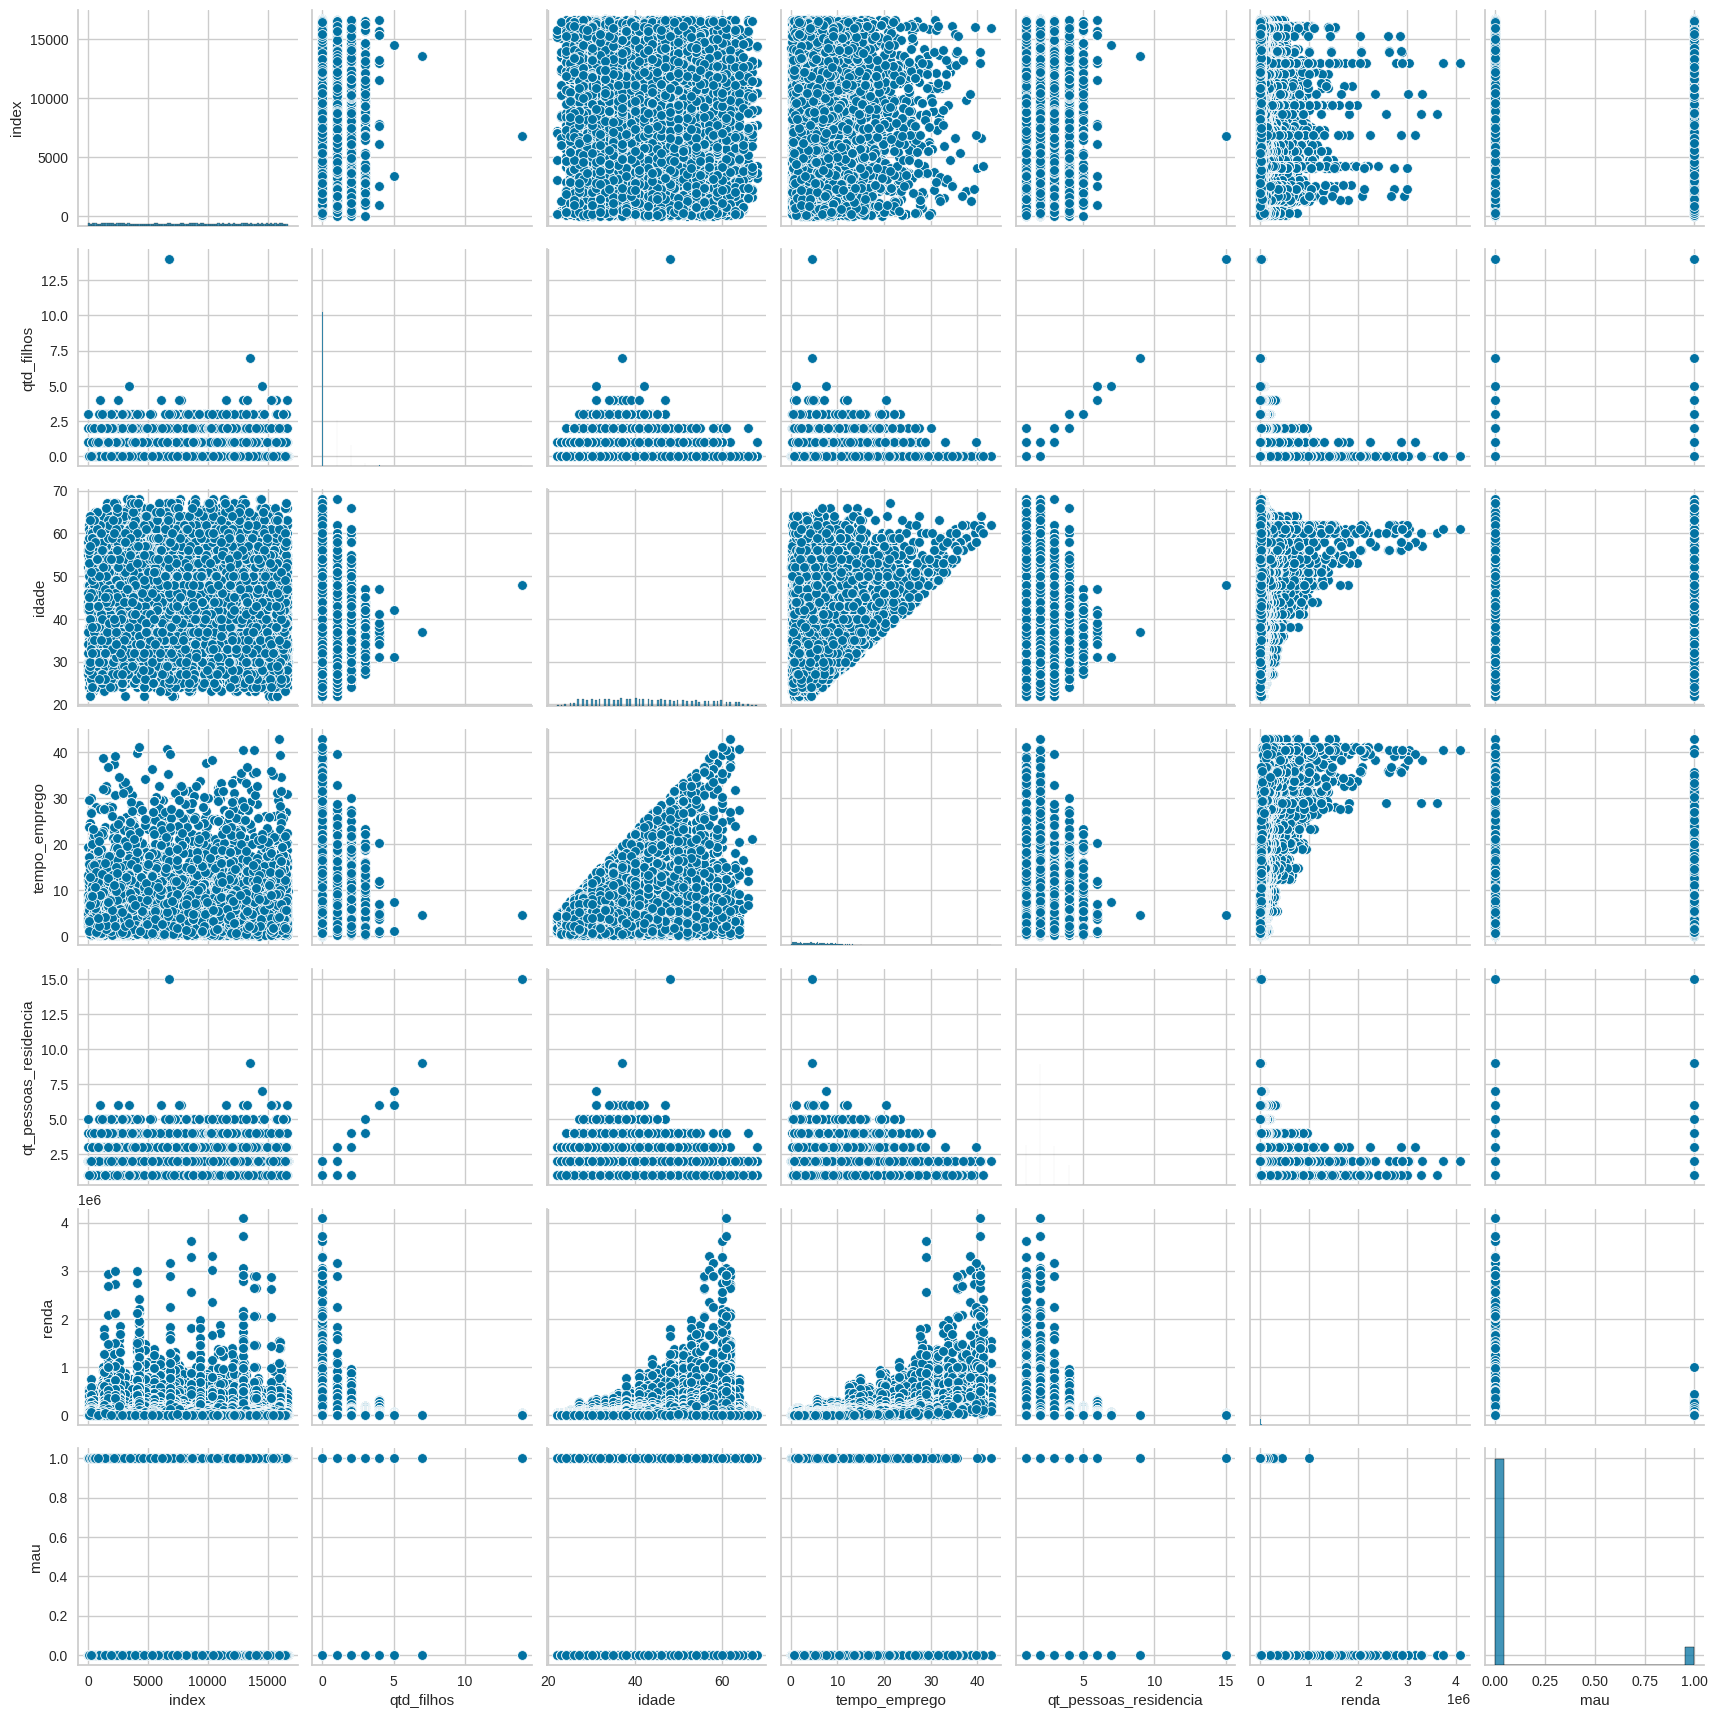

In [11]:
# Matriz de gráficos de dispersão para uma análise descritiva bivariada
sns.pairplot(df)

# Exibindo os gráficos
plt.show()

## Desenvolvimento do modelo

Desenvolva um modelo de *credit scoring* através de uma regressão logística.

- Trate valores missings e outliers
- Trate 'zeros estruturais'
- Faça agrupamentos de categorias conforme vimos em aula
- Proponha uma equação preditiva para 'mau'
- Caso hajam categorias não significantes, justifique

In [12]:
# Tratamento de valores missing
# Preenchendo os valores missing com a média (para variáveis numéricas) ou a moda (para variáveis categóricas)
for col in df.columns:
    if df[col].dtype == 'object':
        df[col].fillna(df[col].mode()[0], inplace=True)
    else:
        df[col].fillna(df[col].mean(), inplace=True)

print(df.isnull().sum()) # verifica se há valores nulos

data_ref                 0
index                    0
sexo                     0
posse_de_veiculo         0
posse_de_imovel          0
qtd_filhos               0
tipo_renda               0
educacao                 0
estado_civil             0
tipo_residencia          0
idade                    0
tempo_emprego            0
qt_pessoas_residencia    0
renda                    0
mau                      0
dtype: int64


In [13]:
# Tratamento de outliers
# Substituindo os outliers pelo valor do percentil 95 (para valores altos) ou percentil 5 (para valores baixos)
for col in df.select_dtypes(include=[np.number]).columns:
    P95 = df[col].quantile(0.95)
    P5 = df[col].quantile(0.05)
    df[col] = np.where(df[col] > P95, P95, df[col])
    df[col] = np.where(df[col] < P5, P5, df[col])

# Tratamento de 'zeros estruturais'
# Substituindo os 'zeros estruturais' pela mediana
for col in df.select_dtypes(include=[np.number]).columns:
    median = df.loc[df[col] != 0, col].median()
    df[col] = np.where(df[col] == 0, median, df[col])

# Tratamento de variáveis de data/hora
# Substituindo a variável de data/hora por várias variáveis numéricas
for col in df.select_dtypes(include=['datetime64']).columns:
    df[col+'_ano'] = df[col].dt.year
    df[col+'_mes'] = df[col].dt.month
    df[col+'_dia'] = df[col].dt.day
    df[col+'_dia_da_semana'] = df[col].dt.weekday
    df = df.drop(col, axis=1)

In [14]:
# Agrupamento de categorias
# Agrupando as categorias com frequências muito baixas em uma única categoria 'Outros'
for col in df.select_dtypes(include=['object']).columns:
    freq = df[col].value_counts(normalize=True)
    small_categories = freq[freq < 0.01].index
    df[col] = np.where(df[col].isin(small_categories), 'Outros', df[col])

# Codificação das variáveis categóricas
df = pd.get_dummies(df, drop_first=True)

In [15]:
# Separação das variáveis independentes e dependente
X = df.drop('mau', axis=1)
y = df['mau']

In [16]:
# Divisão dos dados em conjuntos de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [17]:
# Padronização das variáveis independentes
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [18]:
# Ajuste do modelo de regressão logística
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [19]:
# Previsões do modelo
y_pred = model.predict(X_test)

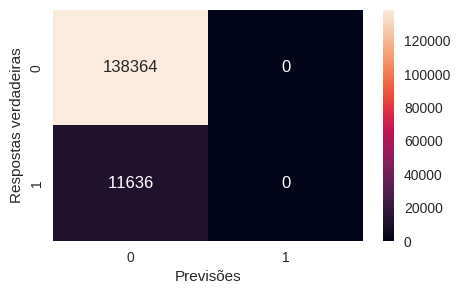

In [20]:
# Avaliação do modelo:

# Calcula a matriz de confusão
cm = confusion_matrix(y_test, y_pred)

# Cria um heatmap a partir da matriz de confusão
plt.figure(figsize=(5,3))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Previsões')
plt.ylabel('Respostas verdadeiras')

plt.show()

A matriz de confusão indica que o modelo fez as seguintes previsões:

- **Verdadeiros negativos (TN)**: O modelo previu corretamente **138364** instâncias como negativas (primeiro número na matriz).
- **Falsos positivos (FP)**: O modelo previu incorretamente **0** instâncias como positivas quando na verdade eram negativas (segundo número na matriz).
- **Falsos negativos (FN)**: O modelo previu incorretamente **11636** instâncias como negativas quando na verdade eram positivas (terceiro número na matriz).
- **Verdadeiros positivos (TP)**: O modelo previu corretamente **0** instâncias como positivas (quarto número na matriz).

Isso sugere que o modelo está classificando todas as instâncias como negativas, o que pode indicar um problema.

In [21]:
# Avaliação do modelo
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.92      1.00      0.96    138364
        True       0.00      0.00      0.00     11636

    accuracy                           0.92    150000
   macro avg       0.46      0.50      0.48    150000
weighted avg       0.85      0.92      0.89    150000




- **False**: As métricas para a classe "False" (ou negativa) são:
    - **Precision**: Dos exemplos que o modelo previu como "False", 92% eram realmente "False".
    - **Recall**: Dos exemplos que eram realmente "False", o modelo previu corretamente 100% deles como "False".
    - **F1-score**: É a média harmônica da precisão e do recall, fornecendo um equilíbrio entre ambos. Neste caso, é 96%.

- **True**: As métricas para a classe "True" (ou positiva) são:
    - **Precision**: Dos exemplos que o modelo previu como "True", 0% eram realmente "True".
    - **Recall**: Dos exemplos que eram realmente "True", o modelo previu corretamente 0% deles como "True".
    - **F1-score**: Neste caso, é 0%, indicando que o modelo não está performando bem na classe "True".

- **Accuracy**: A proporção de previsões corretas do modelo. Neste caso, o modelo fez previsões corretas para 92% dos exemplos.

- **Macro avg**: A média das métricas para as classes "True" e "False", sem levar em conta o desequilíbrio de classe. Neste caso, a precisão média é 46%, o recall médio é 50% e o F1-score médio é 48%.

- **Weighted avg**: A média das métricas para as classes "True" e "False", ponderada pelo número de exemplos em cada classe. Neste caso, a precisão ponderada é 85%, o recall ponderado é 92% e o F1-score ponderado é 89%.

Isto sugere que o modelo está performando bem na classe "False", mas não está conseguindo prever corretamente a classe "True". Isso pode ser devido a um desequilíbrio de classe no conjunto de dados ou a características do modelo.

## Avaliação do modelo

Avalie o poder discriminante do modelo pelo menos avaliando acurácia, KS e Gini.

Avalie estas métricas nas bases de desenvolvimento e *out of time*.

In [22]:
# Calculando a acurácia
accuracy = accuracy_score(y_test, y_pred)
print(f'Acurácia: {accuracy}')

# Calculando o KS
ks_statistic, ks_pvalue = ks_2samp(y_pred[y_test == 0], y_pred[y_test == 1])
print(f'KS: {ks_statistic}')

# Calculando o Gini
roc_auc = roc_auc_score(y_test, y_pred)
gini = 2*roc_auc - 1
print(f'Gini: {gini}')

Acurácia: 0.9224266666666666
KS: 0.0
Gini: 0.0


Estas são métricas de avaliação do modelo:

- **Acurácia**: A acurácia do modelo é de 92.24%. Isso significa que o modelo fez previsões corretas para 92.24% dos exemplos.

- **KS (Kolmogorov-Smirnov)**: O valor KS é 0.0. O KS é uma medida da separação entre as distribuições de eventos positivos e negativos. Um valor KS de 0 indica que o modelo não tem poder discriminatório, ou seja, não consegue distinguir entre a classe positiva e a classe negativa.

- **Gini**: O coeficiente de Gini é 0.0. O coeficiente de Gini é uma medida da desigualdade ou impureza de uma distribuição. Um valor de Gini de 0 indica que o modelo não tem poder discriminatório.


# a - Criar um pipeline utilizando o sklearn pipeline para o preprocessamento

## Pré processamento

### Substituição de nulos (nans)

Existe nulos na base? é dado numérico ou categórico? qual o valor de substituição? média? valor mais frequente? etc

In [23]:
# Recarregando a base de dados
df = pd.read_feather('credit_scoring.ftr')

df.drop(['data_ref', 'index'], axis=1, inplace=True)

In [ ]:
df.info()

In [25]:
#Criando função para verificar se há nulos na base se True e numerico substitui pela média se true e categórico drop.
def verifica_nulos(df):
    for coluna in df.columns:
        if df[coluna].isnull().sum() > 0:
            if df[coluna].dtype in [np.float64, np.int64]:
                df[coluna].fillna(df[coluna].mean(), inplace=True)
            else:
                df.dropna(subset=[coluna], inplace=True)
    return df


verifica_nulos(df)

,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
0,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,False
1,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,False
2,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.29,False
3,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.772603,2.0,13721.17,False
4,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.432877,1.0,2891.08,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
749995,M,N,S,0,Empresário,Superior completo,Casado,Casa,48,3.038356,2.0,2109.99,False
749996,F,N,S,0,Pensionista,Médio,Solteiro,Casa,65,7.748574,1.0,1389.39,False
749997,M,S,N,2,Assalariado,Médio,Casado,Casa,43,10.375342,4.0,649.06,True
749998,F,N,S,0,Assalariado,Médio,Viúvo,Casa,56,13.780822,1.0,4216.72,True


In [26]:
df.isnull().sum()

sexo                     0
posse_de_veiculo         0
posse_de_imovel          0
qtd_filhos               0
tipo_renda               0
educacao                 0
estado_civil             0
tipo_residencia          0
idade                    0
tempo_emprego            0
qt_pessoas_residencia    0
renda                    0
mau                      0
dtype: int64

### Remoção de outliers

Como identificar outlier? Substituir o outlier por algum valor? Remover a linha?

In [27]:
df.shape

(750000, 13)

In [28]:
def remove_outliers_iqr(df):
    for coluna in df.columns:
        if np.issubdtype(df[coluna].dtype, np.number):
            # Valores do quartil 25 e quartil 75
            q25, q75 = np.percentile(df[coluna],
                                     25), np.percentile(df[coluna], 75)

            # Interquartile range
            coluna_iqr = q75 - q25

            # Limiar
            coluna_cut_off = coluna_iqr * 1.5
            # Limite superior e inferior
            coluna_lower, coluna_upper = q25 - coluna_cut_off, q75 + coluna_cut_off

            # DataFrame sem os outliers
            df = df[(df[coluna] >= coluna_lower)
                    & (df[coluna] <= coluna_upper)].copy()

    return df


df = remove_outliers_iqr(df)

df.shape

(625133, 13)

### Seleção de variáveis

Qual tipo de técnica? Boruta? Feature importance?

In [29]:
#Criando função para seleção de variáveis



def seleciona_variaveis(df, target):
    # Separando os dados em features (X) e variável alvo (y)
    X = df.drop(target, axis=1)
    y = df[target]

    # Aplicando a codificação one-hot para as colunas categóricas
    categorical_cols = df.select_dtypes(include=['object']).columns
    X = pd.get_dummies(X, columns=categorical_cols)

    # Criando o modelo de RandomForestClassifier
    model = RandomForestClassifier()

    # Treinando o modelo
    model.fit(X, y)

    # Obtendo a importância das features
    feature_importance = pd.Series(
        model.feature_importances_,
        index=X.columns).sort_values(ascending=False)

    # Retornando as top N variáveis mais importantes
    N = 8  # Defina o número de variáveis que deseja manter
    top_features = feature_importance[:N]

    return top_features


seleciona_variaveis(df, 'mau')

renda                    0.786468
tempo_emprego            0.078668
idade                    0.072504
qt_pessoas_residencia    0.007292
qtd_filhos               0.005819
educacao_Médio           0.003360
posse_de_veiculo_S       0.003282
posse_de_veiculo_N       0.003276
dtype: float64

### Redução de dimensionalidade (PCA)

Aplicar PCA para reduzir a dimensionalidade para 5

In [30]:
def pca(df, target):

    # Separando os dados em features (X) e variável alvo (y)
    X = df.drop(target, axis=1)
    y = df[target]

    # Aplicando a codificação one-hot para as colunas categóricas
    categorical_cols = df.select_dtypes(include=['object']).columns
    X = pd.get_dummies(X, columns=categorical_cols)

    # Criando uma instância do PCA com o número de componentes desejado
    n_components = 5
    pca = PCA(n_components=n_components)
    pca.fit(X)

    # Ajustando o PCA aos dados
    X_pca = pca.transform(X)

    # Criando um DataFrame para as componentes principais
    pca_df = pd.DataFrame(data=X_pca)

    return pca_df


pca(df, 'mau')

,0,1,2,3,4
0,-6172.423188,0.244678,1.713633,-1.683200,-0.347175
1,-5507.624183,-8.004240,-0.060870,-0.372437,0.334239
2,-7105.525140,-12.275394,-3.697594,1.801498,-1.304870
3,5033.358418,10.615286,5.117933,-0.156054,-0.268969
4,-5796.733914,-11.642028,4.180024,-1.825262,0.676844
...,...,...,...,...,...
625128,-6577.823343,4.903569,-2.455139,-0.006112,0.319048
625129,-7298.421276,22.361618,0.977159,-0.840425,-0.317004
625130,-8038.752625,0.543297,5.542137,2.515742,0.861814
625131,-4471.091123,13.600633,7.295678,-1.080662,-0.245168


### Criação de dummies

Aplicar o get_dummies() ou onehotencoder() para transformar colunas catégoricas do dataframe em colunas de 0 e 1.
- sexo
- posse_de_veiculo
- posse_de_imovel
- tipo_renda
- educacao
- estado_civil
- tipo_residencia

In [31]:
df.dtypes

sexo                      object
posse_de_veiculo          object
posse_de_imovel           object
qtd_filhos                 int64
tipo_renda                object
educacao                  object
estado_civil              object
tipo_residencia           object
idade                      int64
tempo_emprego            float64
qt_pessoas_residencia    float64
renda                    float64
mau                         bool
dtype: object

In [32]:
#Função para get_dummies para columas catégoricas do dataframe
def get_dummies(df):
    df = pd.get_dummies(df, drop_first=True)
    return df


get_dummies(df)

,qtd_filhos,idade,tempo_emprego,qt_pessoas_residencia,renda,mau,sexo_M,posse_de_veiculo_S,posse_de_imovel_S,tipo_renda_Bolsista,...,educacao_Superior incompleto,estado_civil_Separado,estado_civil_Solteiro,estado_civil_União,estado_civil_Viúvo,tipo_residencia_Casa,tipo_residencia_Com os pais,tipo_residencia_Comunitário,tipo_residencia_Estúdio,tipo_residencia_Governamental
0,0,43,6.873973,1.0,2515.39,False,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0
1,0,35,4.526027,2.0,3180.19,False,0,1,1,0,...,0,0,0,0,0,1,0,0,0,0
2,2,31,0.243836,4.0,1582.29,False,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,0,54,12.772603,2.0,13721.17,False,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,0,31,8.432877,1.0,2891.08,False,0,1,0,0,...,1,0,1,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
749995,0,48,3.038356,2.0,2109.99,False,1,0,1,0,...,0,0,0,0,0,1,0,0,0,0
749996,0,65,7.748574,1.0,1389.39,False,0,0,1,0,...,0,0,1,0,0,1,0,0,0,0
749997,2,43,10.375342,4.0,649.06,True,1,1,0,0,...,0,0,0,0,0,1,0,0,0,0
749998,0,56,13.780822,1.0,4216.72,True,0,0,1,0,...,0,0,0,0,1,1,0,0,0,0


### Pipeline

Crie um pipeline contendo essas funções.

preprocessamento()
- substituicao de nulos
- remoção outliers
- PCA
- Criação de dummy de pelo menos 1 variável (posse_de_veiculo)

In [33]:
#criando pipeline preprocessamento()

preprocessamento = Pipeline(
    steps=[('verifica_nulos',
            verifica_nulos(df)), ('remove_outliers',
                                  remove_outliers_iqr(df)), ('pca'),
           pca(df, 'mau'), ('get_dummies', get_dummies(df))])

In [34]:
preprocessamento

Pipeline(steps=[('verifica_nulos',
                        sexo posse_de_veiculo posse_de_imovel  qtd_filhos   tipo_renda  \
0         F                N               N           0   Empresário   
1         F                S               S           0  Assalariado   
2         F                N               N           2  Assalariado   
3         F                N               N           0  Assalariado   
4         F                S               N           0  Assalariado   
...     ...              ...             ...         ...          ...   
749995    M                N               S           0   Empresário   
749996    F                N               S           0  Pensionista   
749997    M                S               N           2  Assalariado   
749998    F                N               S           0  Assalariado   
749999    M                S               N           2  Assalariado   

                   educacao estado_civil tipo_residencia  idade  \
0                     Médio     Solteiro            Casa...
        estado_civil_Viúvo  tipo_residencia_Casa  tipo_residencia_Com os pais  \
0                        0                     1                            0   
1                        0                     1                            0   
2                        0                     1                            0   
3                        0                     1                            0   
4                        0                     1                            0   
...                    ...                   ...                          ...   
749995                   0                     1                            0   
749996                   0                     1                            0   
749997                   0                     1                            0   
749998                   1                     1                            0   
749999                   0                     1                            0   

        tipo_residencia_Comunitário  tipo_residencia_Estúdio  \
0                                 0                        0   
1                                 0                        0   
2                                 0                        0   
3                                 0                        0   
4                                 0                        0   
...                             ...                      ...   
749995                            0                        0   
749996                            0                        0   
749997                            0                        0   
749998                            0                        0   
749999                            0                        0   

        tipo_residencia_Governamental  
0                                   0  
1                                   0  
2                                   0  
3                                   0  
4                                   0  
...                               ...  
749995                              0  
749996                              0  
749997                              0  
749998                              0  
749999                              0  

[625133 rows x 26 columns])])

# b - Pycaret na base de dados

Utilize o pycaret para pre processar os dados e rodar o modelo **lightgbm**. Faça todos os passos a passos da aula e gere os gráficos finais. E o pipeline de toda a transformação.



In [35]:
import pandas as pd

df = pd.read_feather('credit_scoring.ftr')
df.head()

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
0,2015-01-01,5733,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,False
1,2015-01-01,727,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,False
2,2015-01-01,6374,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.29,False
3,2015-01-01,9566,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.772603,2.0,13721.17,False
4,2015-01-01,9502,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.432877,1.0,2891.08,False


In [37]:
dataset = df.sample(50000)
dataset.drop(['data_ref', 'index'], axis=1, inplace=True)

In [38]:
data = dataset.sample(frac=0.95, random_state=786)
data_unseen = dataset.drop(data.index)
data.reset_index(inplace=True, drop=True)
data_unseen.reset_index(inplace=True, drop=True)
print('Conjunto de dados para modelagem (treino e teste): ' + str(data.shape))
print('Conjunto de dados não usados no treino/teste, apenas como validação: ' +
      str(data_unseen.shape))

Conjunto de dados para modelagem (treino e teste): (47500, 13)
Conjunto de dados não usados no treino/teste, apenas como validação: (2500, 13)


In [39]:
exp_clf101 = setup(data=data, target='mau', session_id=123)

,Description,Value
0,Session id,123
1,Target,mau
2,Target type,Binary
3,Original data shape,"(47500, 13)"
4,Transformed data shape,"(47500, 30)"
5,Transformed train set shape,"(33250, 30)"
6,Transformed test set shape,"(14250, 30)"
7,Ordinal features,3
8,Numeric features,5
9,Categorical features,7


In [40]:
data.dtypes

sexo                      object
posse_de_veiculo          object
posse_de_imovel           object
qtd_filhos                 int64
tipo_renda                object
educacao                  object
estado_civil              object
tipo_residencia           object
idade                      int64
tempo_emprego            float64
qt_pessoas_residencia    float64
renda                    float64
mau                         bool
dtype: object

In [41]:
models()

,Name,Reference,Turbo
ID,,,
lr,Logistic Regression,sklearn.linear_model._logistic.LogisticRegression,True
knn,K Neighbors Classifier,sklearn.neighbors._classification.KNeighborsCl...,True
nb,Naive Bayes,sklearn.naive_bayes.GaussianNB,True
dt,Decision Tree Classifier,sklearn.tree._classes.DecisionTreeClassifier,True
svm,SVM - Linear Kernel,sklearn.linear_model._stochastic_gradient.SGDC...,True
rbfsvm,SVM - Radial Kernel,sklearn.svm._classes.SVC,False
gpc,Gaussian Process Classifier,sklearn.gaussian_process._gpc.GaussianProcessC...,False
mlp,MLP Classifier,sklearn.neural_network._multilayer_perceptron....,False
ridge,Ridge Classifier,sklearn.linear_model._ridge.RidgeClassifier,True


In [42]:
lgbm = create_model('lightgbm', fix_imbalance=True)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9245,0.7675,0.0198,0.5556,0.0383,0.0333,0.0944
1,0.9230,0.7657,0.0079,0.2500,0.0154,0.0108,0.0323
2,0.9227,0.7725,0.0158,0.3333,0.0302,0.0235,0.0584
3,0.9233,0.7699,0.0000,0.0000,0.0000,-0.0012,-0.0070
4,0.9236,0.7768,0.0198,0.4545,0.0379,0.0317,0.0822
5,0.9230,0.7370,0.0040,0.2000,0.0078,0.0048,0.0181
6,0.9248,0.7862,0.0395,0.5882,0.0741,0.0651,0.1385
7,0.9239,0.7717,0.0158,0.5000,0.0307,0.0261,0.0785
8,0.9233,0.7485,0.0040,0.2500,0.0078,0.0054,0.0228


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [43]:
tuned_lgbm = tune_model(lgbm, optimize='F1')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9140,0.7335,0.0556,0.2258,0.0892,0.0611,0.0781
1,0.9113,0.7389,0.0635,0.2133,0.0979,0.0654,0.0789
2,0.9113,0.7273,0.0791,0.2439,0.1194,0.0853,0.1006
3,0.9182,0.7372,0.0909,0.3538,0.1447,0.1172,0.1479
4,0.9104,0.7268,0.0830,0.2414,0.1235,0.0880,0.1022
5,0.9071,0.6916,0.0632,0.1818,0.0938,0.0568,0.0657
6,0.9089,0.7393,0.0672,0.2024,0.1009,0.0654,0.0767
7,0.9116,0.7257,0.0553,0.2029,0.0870,0.0562,0.0696
8,0.9143,0.7236,0.0672,0.2576,0.1066,0.0775,0.0974


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


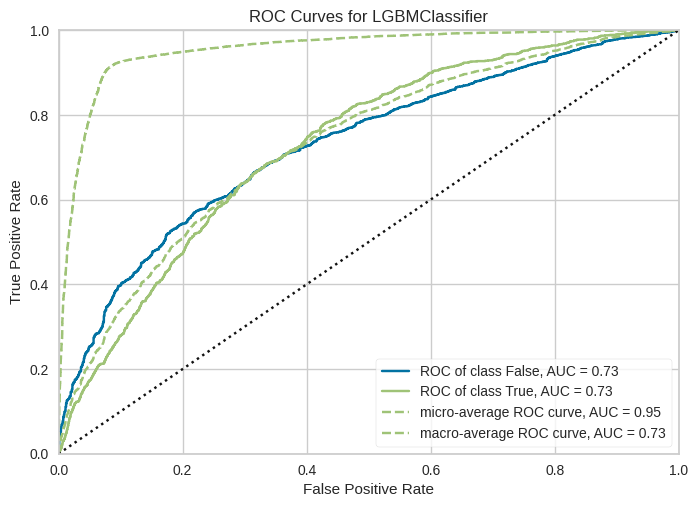

In [44]:
plot_model(tuned_lgbm, plot='auc')

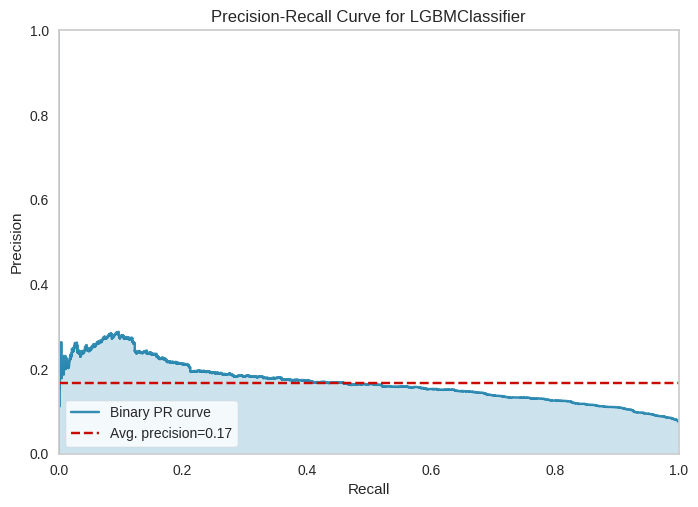

In [45]:
plot_model(tuned_lgbm, plot='pr')

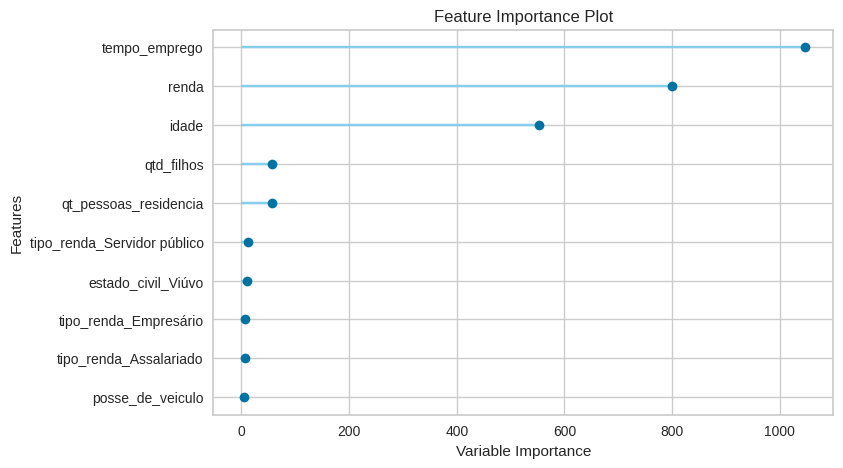

In [46]:
plot_model(tuned_lgbm, plot='feature')

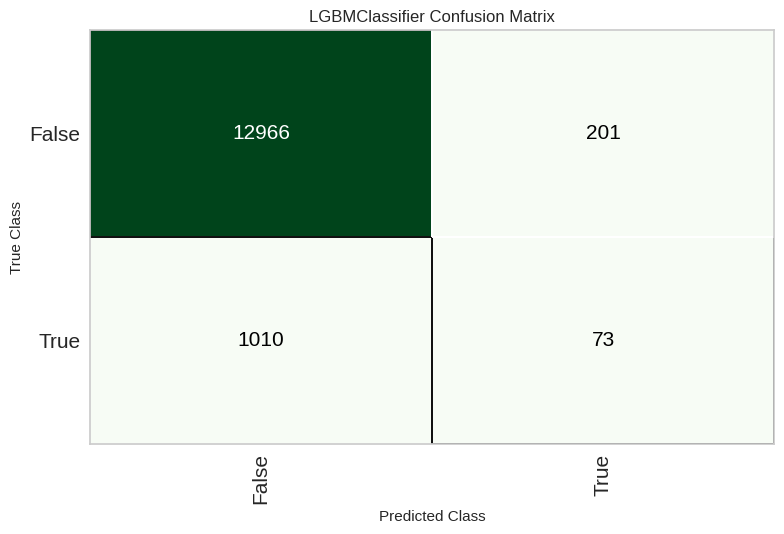

In [47]:
plot_model(tuned_lgbm, plot='confusion_matrix')

In [48]:
##Avaliando na base out of time

predict_model(tuned_lgbm)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.9150,0.7300,0.0674,0.2664,0.1076,0.0793,0.1006


[LightGBM] [Warning] Unknown parameter: fix_imbalance
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] Unknown parameter: fix_imbalance
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9


,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau,prediction_label,prediction_score
43864,F,S,N,1,Assalariado,Superior completo,Casado,Governamental,34,6.800000,3.0,3173.510010,False,0,0.9483
26469,F,S,S,1,Assalariado,Superior completo,Casado,Casa,35,9.120548,3.0,13417.370117,False,0,0.9731
35670,M,S,S,0,Assalariado,Médio,Casado,Casa,53,8.893150,2.0,37351.250000,False,0,0.9952
46338,F,S,N,0,Pensionista,Médio,Casado,Casa,48,NaN,2.0,39927.148438,False,0,0.9978
37009,M,N,S,0,Assalariado,Médio,Casado,Casa,44,8.353425,2.0,19180.169922,False,0,0.9942
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1005,M,S,S,1,Assalariado,Superior incompleto,Casado,Casa,36,0.679452,3.0,1620.800049,False,0,0.7885
26983,M,S,S,1,Empresário,Superior completo,Casado,Casa,34,9.101370,3.0,13331.690430,False,0,0.9449
40250,F,N,S,0,Pensionista,Médio,Casado,Casa,57,NaN,2.0,7745.939941,False,0,0.9361
20971,F,N,S,0,Assalariado,Superior completo,Solteiro,Casa,36,13.542466,1.0,12619.820312,False,0,0.9903


In [49]:
##Preparando para salvar o modelo.
final_lgbm = finalize_model(tuned_lgbm)

In [50]:
#Verificando os parametros.
print(final_lgbm)

Pipeline(memory=Memory(location=None),
         steps=[('numerical_imputer',
                 TransformerWrapper(exclude=None,
                                    include=['qtd_filhos', 'idade',
                                             'tempo_emprego',
                                             'qt_pessoas_residencia', 'renda'],
                                    transformer=SimpleImputer(add_indicator=False,
                                                              copy=True,
                                                              fill_value=None,
                                                              keep_empty_features=False,
                                                              missing_values=nan,
                                                              strategy='mean',
                                                              verbose='deprecated'))),
                ('categorical_im...
                                colsample_bytree=1.0, f

In [51]:
#Salvando localmente.
save_model(final_lgbm, 'Final LGBM Model 10jan2024')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['qtd_filhos', 'idade',
                                              'tempo_emprego',
                                              'qt_pessoas_residencia', 'renda'],
                                     transformer=SimpleImputer(add_indicator=False,
                                                               copy=True,
                                                               fill_value=None,
                                                               keep_empty_features=False,
                                                               missing_values=nan,
                                                               strategy='mean',
                                                               verbose='deprecated'))),
                 ('categorical_im...
                                 colsampl